<a href="https://colab.research.google.com/github/adii-bendre/GenAI-ChatGPT/blob/main/ChatGPT_Model_For_Language_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Gathering Data

In [ ]:
# pip install tensorflow

In [ ]:
import tensorflow as tf


text_file = tf.keras.utils.get_file(
    fname = 'fra-eng.zip',
    origin = 'http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
    extract = True,
)

3423204/3423204 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import pathlib
text_file = pathlib.Path(text_file).parent / 'fra-eng_extracted' / 'fra.txt'

In [ ]:
print(text_file)

/root/.keras/datasets/fra-eng_extracted/fra.txt


In [ ]:
import os

if os.path.exists(text_file):
    with open(text_file) as f:
        lines = f.read().split('\n')[:-1]
    text_pairs = []
else:
    print(f"Error: File not found at {text_file}")

In [ ]:
import os
print(os.listdir('/root/.keras/datasets/'))

['fra-eng_extracted', 'fra-eng.zip']


In [ ]:
with open(text_file) as fp:
  text_pair = [line for line in fp]

In [ ]:
import random
for _ in range(5):
  print(random.choice(text_pair))

Can a child of her age distinguish good from bad?	Une enfant de son âge peut-elle distinguer le bien du mal ?

My uncle lived in Washington, D. C. for two years.	Mon oncle a vécu à Washington pendant deux ans.

Do you let your children drink coffee?	Laissez-vous vos enfants boire du café ?

Tom flipped on the dining room light.	Tom a allumé la lumière de la salle à manger.

It was like that when I bought it.	C'était comme ça quand je l'ai acheté.



In [ ]:
import unicodedata
import re

def normalize(line):
  line = unicodedata.normalize('NFKC', line.strip().lower())
  line = re.sub(r"^([^ \w])(?!\s)",r"\1",line)
  line = re.sub(r"(\s[^ \w])(?!\s)",r"\1",line)
  line = re.sub(r"(?!\s)([^ \w])$",r"\1",line)
  line = re.sub(r"(?!\s)([^ \w]\s)",r"\1",line)
  eng, fre = line.split("\t")
  fre = '[start]'+fre+'[end]'
  return eng, fre

In [ ]:
with open(text_file) as fp:
  text_pairs = [normalize(line) for line in fp]

In [ ]:
for _ in range(5):
  print(random.choice(text_pairs))

("she's not young, is she?", "[start]elle n'est pas jeune, n'est-ce pas ?[end]")
('she smiled at the sight of her mother.', '[start]elle a souri en voyant sa mère.[end]')
("i don't need to know this.", "[start]je n'ai pas besoin de savoir ceci.[end]")
('are you lost?', '[start]es-tu perdue ?[end]')
('normally, i stay at home on sundays.', "[start]d'habitude, je reste à la maison le dimanche.[end]")


In [ ]:
eng_tokens , fre_tokens = set(), set()
eng_maxlen , fre_maxlen = 0, 0
for eng, fre in text_pairs:
  eng_token , fre_token = eng.split(), fre.split()
  eng_maxlen = max(eng_maxlen, len(eng_token))
  fre_maxlen = max(fre_maxlen, len(fre_token))
  eng_tokens.update(eng_token)
  fre_tokens.update(fre_token)

print(f"total token in english {eng_maxlen}")
print(f"total token in french {fre_tokens}")
print(f"maximum length of line is {eng_maxlen}")
print(f"maximum length of line is {fre_maxlen}")

total token in english 47
total token in french {'déploie', 'grâce.[end]', 'offensée.[end]', 'rattraper.[end]', 'n’as', 'texte.[end]', 'tient-elle', 'encombres.[end]', "t'apprécient.[end]", "[start]l'île", "m'aides,", 'dicton', 'faillite.[end]', 'donna', 'soigneusement.[end]', 'glace', 'subitement.[end]', 'intentionnellement,', 'mars.[end]', 'vingt-quatre.[end]', 'reportée.[end]', '[start]tôt', 'ferrée', "m'aperçus", "l'immeuble.[end]", 'manière', 'monstruosités', 'lot,', 'empirer', 'n’étaient', "[start]n'aimerais-tu", 'principe,', "[start]qu'aimez-vous", 'libraire.[end]', "d'accomplir", 'attente,', 'soupiré.[end]', 'grand-mère,', 'susciter', 'hanté.[end]', 'animales,', 'emploies-tu', 'défiance', 'rideaux', 'prendriez', "l'imaginais.[end]", 'énervant.[end]', 'réception', 'blesse.[end]', 'saignait', 'essayez,', 'frime.[end]', 'inquiets.[end]', 'silencieusement', 'polonais', 'enthousiasmé', 'cochons.[end]', 'mérita', 'respectueuse', "[start]l'agneau", 'rats', "l'eau", 'eux-mêmes.[end]', 

In [ ]:
import pickle

with open("text_pairs.pickle",'wb') as fp:
  pickle.dump(text_pairs,fp)

In [ ]:
## Data Transformation

In [ ]:
## 1)Embedding Layer

In [ ]:
from tensorflow.keras.layers import TextVectorization

import pickle

with open("text_pairs.pickle",'rb') as fp:
  text_pairs = pickle.load(fp)

In [ ]:
random.shuffle(text_pairs)

In [ ]:
n_val = int(.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pair = text_pairs[:n_train]
test_pair = text_pairs[n_train + n_val:]

In [ ]:
vocab_en = 10000
vocab_fr = 20000
seq_len = 25

In [ ]:
eng_vect = TextVectorization(
    max_tokens = vocab_en,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_len
)

In [ ]:
fre_vect = TextVectorization(
    max_tokens = vocab_fr,
    standardize = None,
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = seq_len + 1
)

In [ ]:
train_eng = [pair[0] for pair in train_pair]
train_fre = [pair[1] for pair in train_pair]

In [ ]:
eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)

In [ ]:
with open('Vectorize.pickle','wb') as fp:
  data = {'train':train_pair,
          'test':test_pair,
          'eng_vect_config':eng_vect.get_config(),
          'eng_vect_weights':eng_vect.get_weights(),
          'fre_vect_config':fre_vect.get_config(),
          'fre_vect_weights':fre_vect.get_weights()
          }
  pickle.dump(data,fp)

In [ ]:
with open("Vectorize.pickle",'rb') as fp:
  data = pickle.load(fp)

In [ ]:
train_pair = data ['train']
test_pair = data ['test']

In [ ]:
eng_vect = TextVectorization.from_config(data['eng_vect_config'])
eng_vect.set_weights(data['eng_vect_weights'])
fre_vect = TextVectorization.from_config(data['fre_vect_config'])
fre_vect.set_weights(data['fre_vect_weights'])

# Re-adapt the vectorizers to the training data after loading
train_eng = [pair[0] for pair in train_pair]
train_fre = [pair[1] for pair in train_pair]
eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)

In [ ]:
def format_dataset(eng,fre):
  eng = eng_vect(eng)
  fre = fre_vect(fre)

  source = {'encode_inp':eng,
            'decode_inp': fre[:,:-1]
           }
  target = fre[:,1:]
  return (source,target)

def make_dataset(pairs, batchsize = 64):
  eng_text, fre_text = zip(*pairs)
  dataset = tf.data.Dataset.from_tensor_slices((list(eng_text), list(fre_text)))

  return dataset.shuffle(2018).batch(batchsize).map(format_dataset).prefetch(16).cache()

In [ ]:
test_pair

[('we know how important this is.',
  "[start]nous savons à quel point c'est important.[end]"),
 ("i'd like to improve my french.",
  "[start]j'aimerais améliorer mon français.[end]"),
 ("i'm really unhappy about this.",
  '[start]je suis vraiment malheureux à ce sujet.[end]'),
 ("i don't really want to be all by myself.",
  '[start]je ne veux pas vraiment être toute seule.[end]'),
 ('you forgot to buy lettuce.',
  "[start]tu as oublié d'acheter de la salade.[end]"),
 ("maybe you don't know this, but nobody could ever take your place.",
  '[start]peut-être ne le sais-tu pas, mais personne ne pourrait te remplacer.[end]'),
 ('please tell me what happened.',
  "[start]dis-moi, je te prie, ce qu'il s'est passé ![end]"),
 ("you're awesome.", '[start]tu es géniale.[end]'),
 ("i hope i'm not bothering anybody.",
  "[start]j'espère que je ne vais déranger personne.[end]"),
 ("i don't have a lot of time.",
  '[start]je ne dispose pas de beaucoup de temps.[end]'),
 ('i beat him at chess.', "[st

In [ ]:
train_ds = make_dataset(train_pair)
test_ds = make_dataset(test_pair)

In [ ]:
for inputs, target in train_ds.take(1):
  print(inputs['encode_inp'].shape)
  print(inputs['encode_inp'][0])
  print(inputs['decode_inp'].shape)
  print(inputs['decode_inp'][0])
  print(target.shape)
  print(target[0])

(64, 25)
tf.Tensor(
[ 110 2369   10  204   55  171    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)
(64, 25)
tf.Tensor(
[2088  260 3135  411 1002 3456    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)
(64, 25)
tf.Tensor(
[ 260 3135  411 1002 3456    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


In [ ]:
## 2)Positional Encoding

In [ ]:
import numpy as np
import tensorflow as tf

def pos_enc_matrix(L,d,n = 10000):

  assert d%2 == 0
  d2 = d//2

  p = np.zeros((L,d))
  k = np.arange(L).reshape(-1,1)
  i = np.arange(d2).reshape(1,-1)

  denom = np.power(n,-i/d2)
  args = k*denom

  p[:, ::2] = np.sin(args)
  p[:, 1::2] = np.cos(args)
  return p

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
def pos_enc_matrix(L,d,n = 10000):

  assert d%2 == 0
  d2 = d//2

  p = np.zeros((L,d))
  k = np.arange(L).reshape(-1,1)
  i = np.arange(d2).reshape(1,-1)

  denom = np.power(n,-i/d2)
  args = k*denom

  p[:, ::2] = np.sin(args)
  p[:, 1::2] = np.cos(args)
  return p

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, seq_len, vocab_size, embed_dim, **kwargs):

    super().__init__(**kwargs)
    self.seq_len = seq_len
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.token_embeddings = tf.keras.layers.Embedding(
        input_dim = vocab_size,
        output_dim = embed_dim,
        mask_zero = True
    )
    matrix = pos_enc_matrix(seq_len, embed_dim)
    self.positional_embedding = tf.constant(matrix, dtype = tf.float32)

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    return embedded_tokens + self.positional_embedding

  def compute_mask(self, *args, **kwargs):
    return self.token_embeddings.compute_mask(*args, **kwargs)

  def get_config(self):
    config = super().get_config()
    config.update({
        'seq_length':self.seq_len,
        'vocab_size':self.vocab_size,
        'embed_dim':self.embed_dim
    })
    return config

In [ ]:
vocab_en = 10000
vocab_fr = 20000
seq_length = 25

In [ ]:
for inputs, targets in train_ds.take(1):
  print(inputs['encode_inp'])
  embed_en = PositionalEncoding(seq_length, vocab_en, embed_dim = 512)
  en_emb = embed_en(inputs['encode_inp'])
  print(en_emb) # Print the embedded output instead of mask attribute
  en_mask = embed_en.compute_mask(inputs['encode_inp']) # Compute the mask
  print(en_mask) # Print the computed mask

tf.Tensor(
[[   3   53 1279 ...    0    0    0]
 [   5  511   16 ...    0    0    0]
 [  59    7   18 ...    0    0    0]
 ...
 [  18  302  744 ...    0    0    0]
 [   8  138   67 ...    0    0    0]
 [   8  593   36 ...    0    0    0]], shape=(64, 25), dtype=int64)
tf.Tensor(
[[[ 0.00347998  1.0259154   0.01440335 ...  1.0373201  -0.04389796
    1.0180943 ]
  [ 0.8137963   0.49522346  0.84617263 ...  1.0425215  -0.04787241
    0.9574812 ]
  [ 0.9032545  -0.38448173  0.9788583  ...  1.0468787   0.03852142
    1.0316385 ]
  ...
  [-0.01039388 -1.024345    0.66177976 ...  1.04286     0.03837655
    1.0330896 ]
  [-0.847763   -0.5572172  -0.22815946 ...  1.0428598   0.03848022
    1.0330894 ]
  [-0.90712094  0.39979485 -0.95043916 ...  1.0428596   0.03858388
    1.0330892 ]]

 [[-0.03122681  0.96567124 -0.0431019  ...  0.98684627 -0.00475031
    0.9528715 ]
  [ 0.886239    0.5834531   0.79163384 ...  0.96415573  0.02482853
    0.9702688 ]
  [ 0.95397276 -0.3704331   0.90335166 ...  0.97

In [ ]:
## 3)Neural Network (Attention Model)

In [ ]:
import tensorflow as tf

In [ ]:
def self_attention(input_shape, prefix = 'att', mask = False, **kwargs):
  inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f"{prefix}_in1")
  attention = tf.keras.layers.MultiHeadAttention(name = f"{prefix}_att1", **kwargs)
  norm = tf.keras.layers.LayerNormalization(name = f"{prefix}_norm1")
  add = tf.keras.layers.Add(name = f"{prefix}_add1")
  attout = attention(query = inputs, value = inputs, key = inputs, use_causal_mask = mask)
  output = norm(add([inputs, attout]))
  model = tf.keras.Model(inputs = inputs, outputs = output, name = f"{prefix}_att")
  return model

In [ ]:
seq_len = 25
key_dim = 128
num_heads = 8

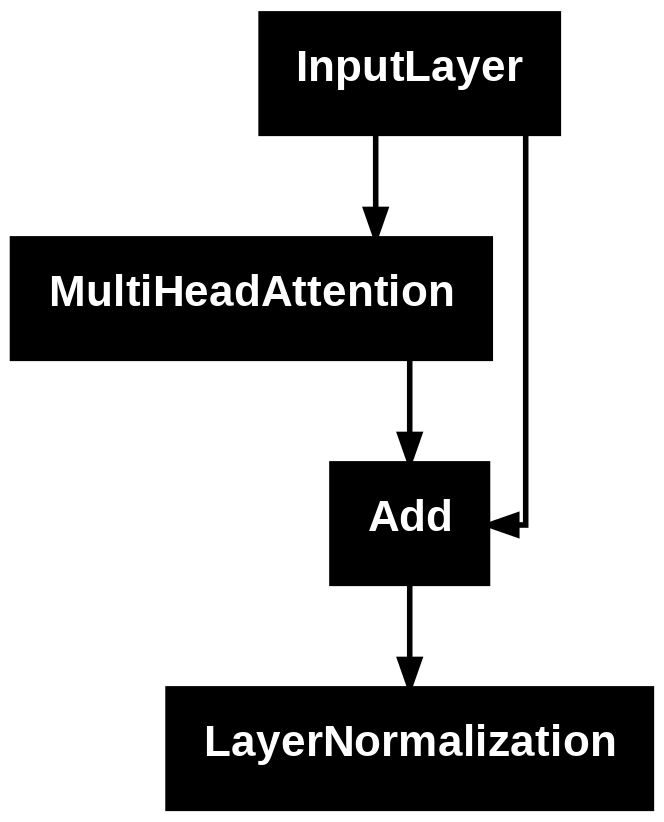

In [ ]:
model = self_attention(input_shape = (seq_length, key_dim), num_heads = num_heads, key_dim = key_dim)
tf.keras.utils.plot_model(model)

In [ ]:
def cross_attention(input_shape, context_shape, prefix = 'att', **kwargs):
  context = tf.keras.layers.Input(shape = context_shape, dtype = 'float32', name = f"{prefix}_ctx2")
  inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f"{prefix}_in2")
  attention = tf.keras.layers.MultiHeadAttention(name = f'{prefix}_att2', **kwargs)
  norm = tf.keras.layers.LayerNormalization(name = f'{prefix}_norm2')
  add = tf.keras.layers.Add(name = f'{prefix}_add2')
  attout = attention(query = inputs, key = context, value = context)
  output = norm(add([attout, inputs]))

  output = norm(add([attout, inputs]))
  model = tf.keras.Model(inputs = [context, inputs], outputs = output, name = f'{prefix}_crs_at')
  return model

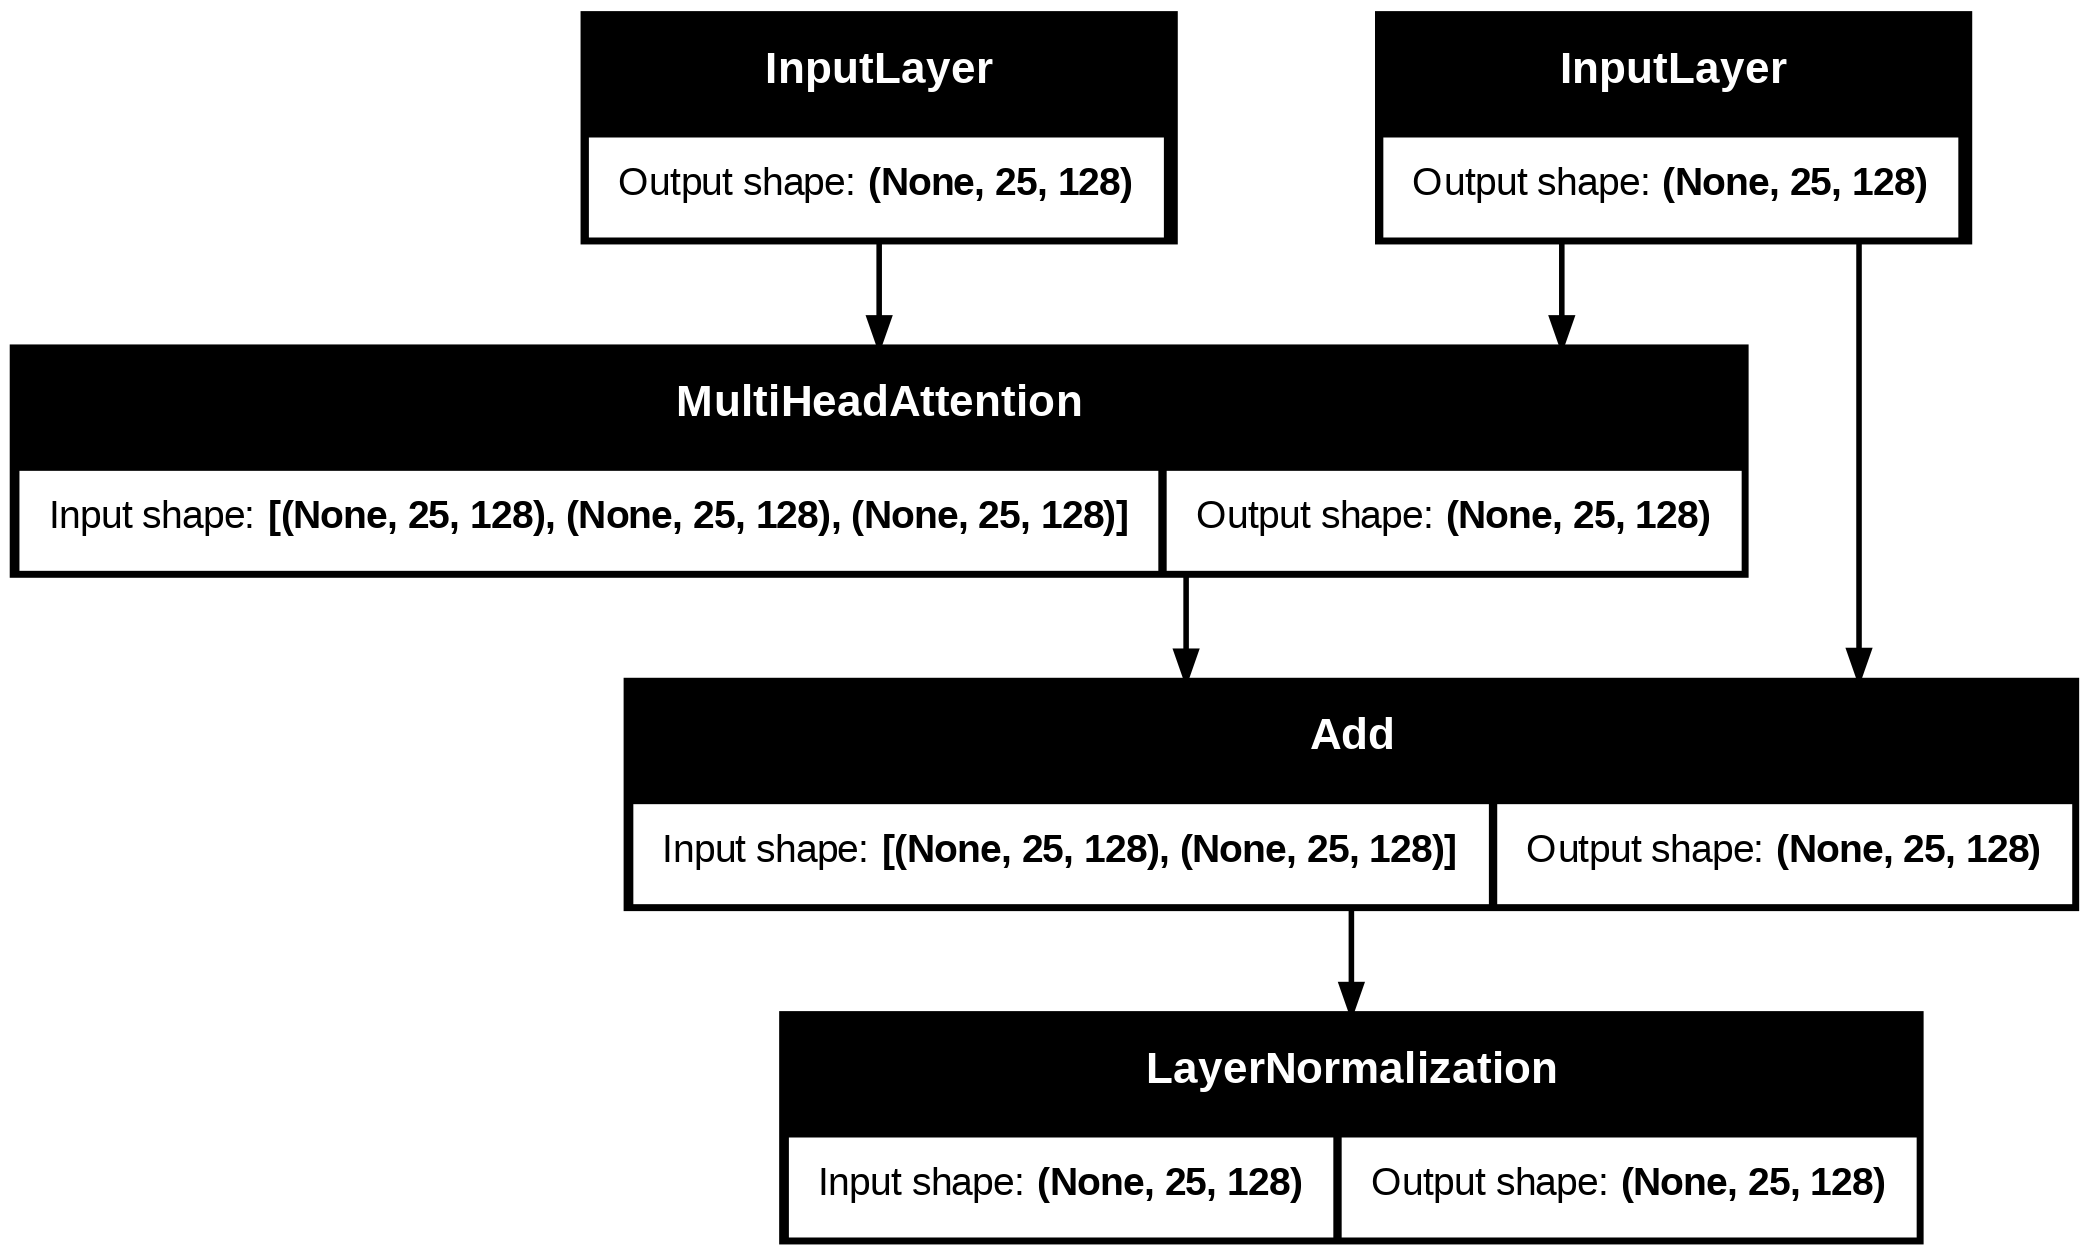

In [ ]:
model = cross_attention(input_shape = (seq_len, key_dim), num_heads = num_heads, key_dim = key_dim, context_shape = (seq_len, key_dim))
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_activations = True)

In [ ]:
def feed_forward(input_shape, model_dim, ff_dim, dropout = 0.1, prefix = 'ff'):
  inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in3')
  dense1 = tf.keras.layers.Dense(ff_dim, name = f'{prefix}_ff1', activation = 'relu')
  dense2 = tf.keras.layers.Dense(model_dim, name = f'{prefix}_ff2')
  drop = tf.keras.layers.Dropout(dropout, name = f'{prefix}_drop')
  add = tf.keras.layers.Add(name = f"{prefix}_add3")
  ffout = drop(dense2(dense1(inputs)))
  norm = tf.keras.layers.LayerNormalization(name = f'{prefix}_norm3')
  output = norm(add([inputs,ffout]))
  model = tf.keras.Model(inputs = inputs, outputs = output, name = f'{prefix}_ff')
  return model

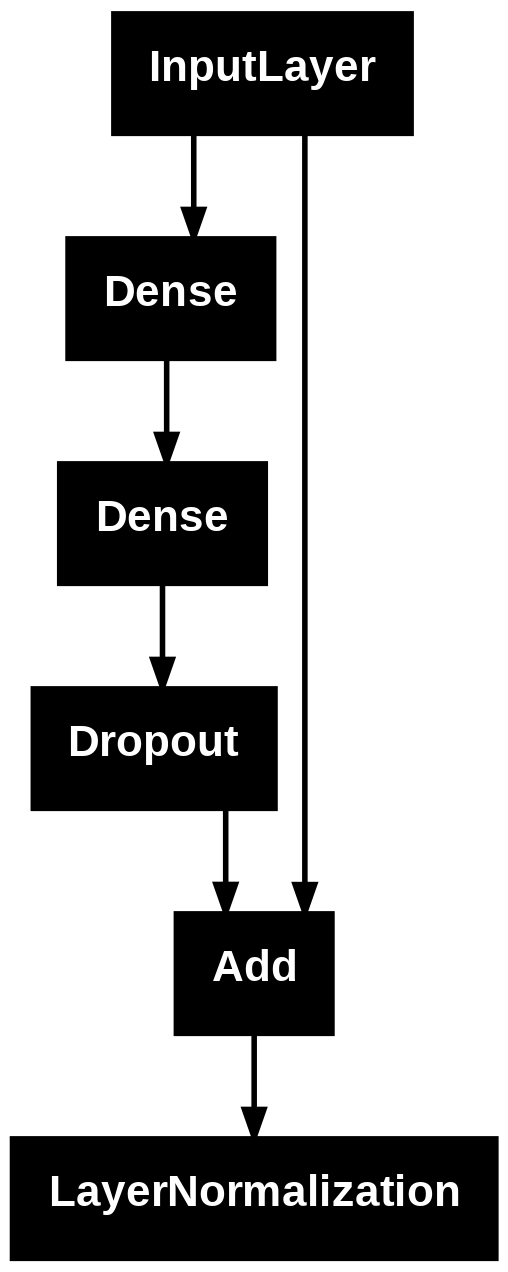

In [ ]:
ff_dim = 512
model = feed_forward(input_shape = (seq_len, key_dim), model_dim = key_dim, ff_dim = ff_dim)
tf.keras.utils.plot_model(model)

In [ ]:
## Encoder Decoder Architecture

In [ ]:
import tensorflow as tf

In [ ]:
def encoder(input_shape, key_dim, ff_dim, dropout = 0.1, prefix = 'enc', **kwargs):

  #Define a sequential model for encounter
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in0'),
      self_attention(input_shape, key_dim = key_dim, prefix = prefix, mask = False, **kwargs),
      feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
  ])

  return model

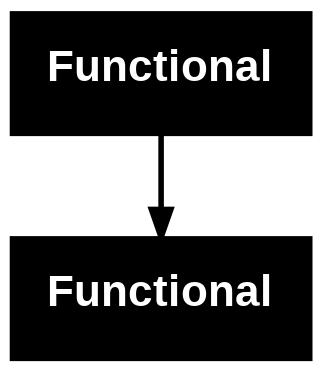

In [ ]:
seq_len = 25
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape = (seq_len, key_dim), key_dim = key_dim, ff_dim = ff_dim, num_heads = num_heads)
tf.keras.utils.plot_model(model)

In [ ]:
def decoder(input_shape, key_dim, ff_dim, dropout = 0.1, prefix = 'dec', **kwargs):
    # Define inputs for decoder
    inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in0')
    context = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_ctx0')

    # Self-attention and cross-attention layers
    att_model = self_attention(input_shape, key_dim = key_dim, mask = True, prefix = prefix, **kwargs)
    cross_model = cross_attention(input_shape = input_shape, context_shape = input_shape, key_dim = key_dim, prefix = prefix, **kwargs)

    # Feed-forward layer
    ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

    # Connect layers
    x = att_model(inputs)
    x = cross_model([context, x])
    output = ff_model(x)

    # Define decoder model
    model = tf.keras.Model(inputs = [inputs, context], outputs = output, name = prefix)

    return model

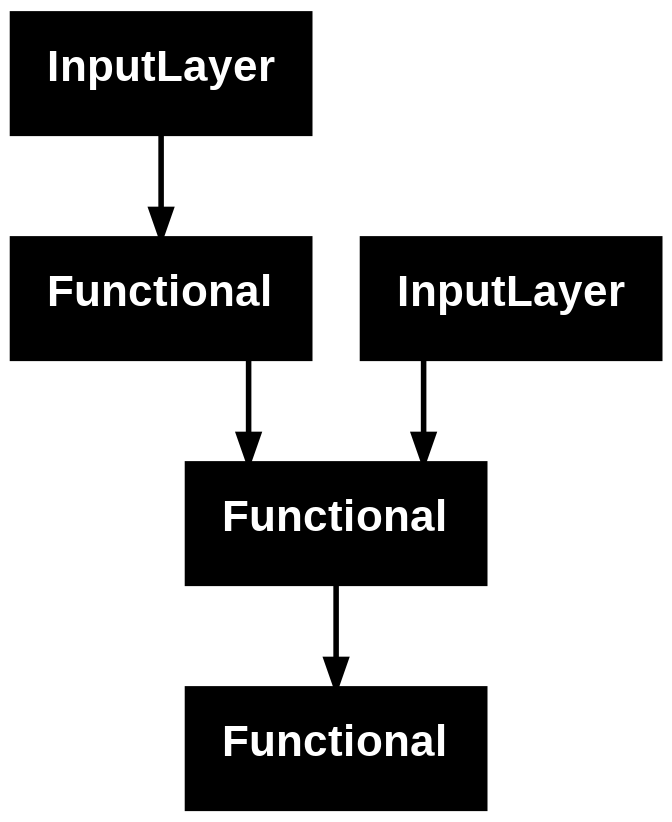

In [ ]:
seq_len = 25
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape = (seq_len, key_dim), key_dim = key_dim, ff_dim = ff_dim, num_heads = num_heads)
tf.keras.utils.plot_model(model)

In [ ]:
## Transformer

In [ ]:
def transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_fr, dropout = 0.1, name = 'transformer'):
    # Define encoder and decoder inputs
    input_enc = tf.keras.layers.Input(shape = (seq_length,), dtype = 'int32', name = 'encode_inp')
    input_dec = tf.keras.layers.Input(shape = (seq_length,), dtype = 'int32', name = 'decode_inp')

    # Positional embeddings for encoder and decoder inputs
    emb_enc = PositionalEncoding(seq_length, vocab_size_en, key_dim, name = 'embed_enc')
    emb_dec = PositionalEncoding(seq_length, vocab_size_fr, key_dim, name = 'embed_dec')

    # Create encoder and decoder layers
    encoders = [encoder(input_shape = (seq_length, key_dim), key_dim = key_dim, ff_dim = ff_dim, dropout = dropout, prefix = f"enc{i}", num_heads = num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape = (seq_length, key_dim), key_dim = key_dim, ff_dim = ff_dim, dropout = dropout, prefix = f"dec{i}", num_heads = num_heads)
                for i in range(num_layers)]

    # Final dense layer
    final = tf.keras.layers.Dense(vocab_size_fr, name='linear')

    # Apply encoder and decoder layers to inputs
    x1 = emb_enc(input_enc)
    x2 = emb_dec(input_dec)

    for layer in encoders:
        x1 = layer(x1)

    for layer in decoders:
        x2 = layer([x2, x1])

    # Generate output
    output = final(x2)

    try:
        del output._keras_mask
    except:
        pass

    # Define transformer model
    model = tf.keras.Model(inputs = [input_enc, input_dec], outputs = output, name = name)

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


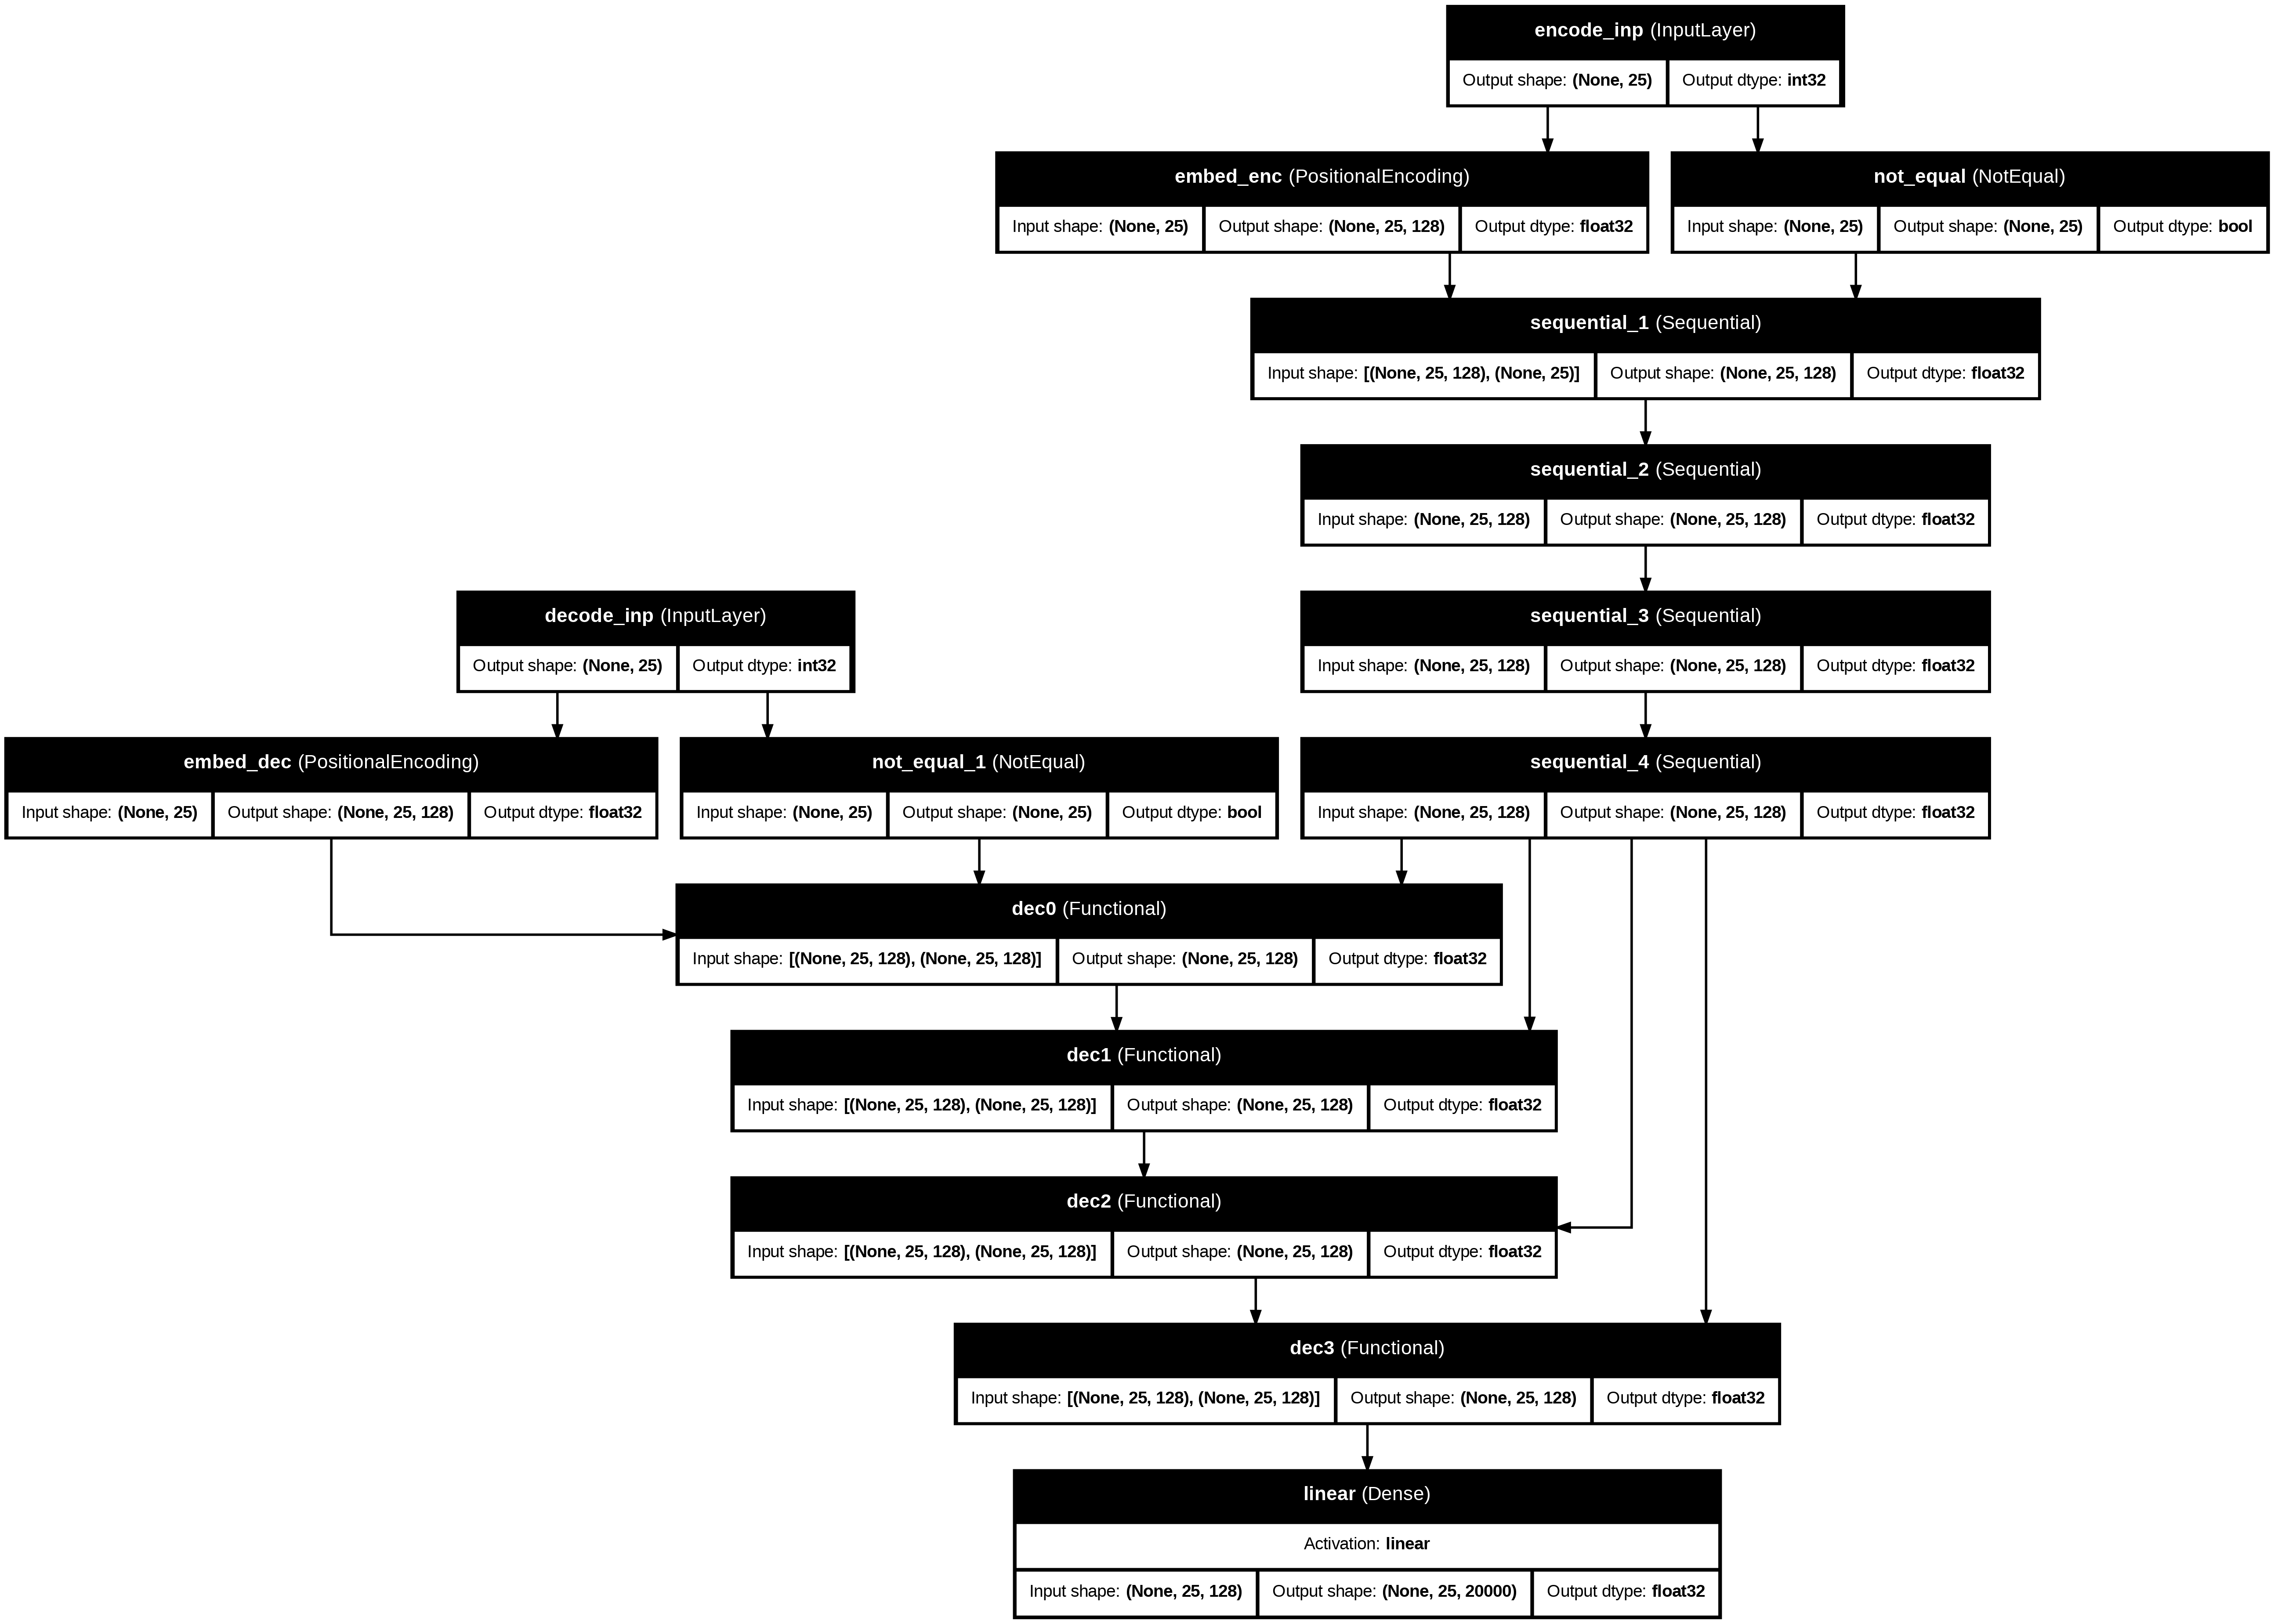

In [ ]:
seq_length = 25
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000

model = transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_fr, dropout)

tf.keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True, show_layer_activations = True)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Training the model

In [ ]:
history = model.fit(train_ds, epochs = 20, validation_data = test_ds)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

1828/1828 ━━━━━━━━━━━━━━━━━━━━ 225s 98ms/step - accuracy: 0.7691 - loss: 3.7968 - val_accuracy: 0.7714 - val_loss: 3.6873
Epoch 2/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 164s 90ms/step - accuracy: 0.7727 - loss: 3.6655 - val_accuracy: 0.7714 - val_loss: 3.6873
Epoch 3/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 165s 90ms/step - accuracy: 0.7727 - loss: 3.6655 - val_accuracy: 0.7714 - val_loss: 3.6873
Epoch 4/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 167s 91ms/step - accuracy: 0.7727 - loss: 3.6655 - val_accuracy: 0.7714 - val_loss: 3.6873
Epoch 5/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 167s 92ms/step - accuracy: 0.7727 - loss: 3.6655 - val_accuracy: 0.7714 - val_loss: 3.6873
Epoch 6/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 169s 92ms/step - accuracy: 0.7727 - loss: 3.6655 - val_accuracy: 0.7714 - val_loss: 3.6873
Epoch 7/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 168s 92ms/step - accuracy: 0.7727 - loss: 3.6655 - val_accuracy: 0.7714 - val_loss: 3.6873
Epoch 8/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 200s 91ms/step - accuracy: 0.7727 - lo

In [ ]:
class customSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,key_dim,warmup_steps = 40000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, dtype = tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        "key_dim":self.key_dim,
        "warmup_steps":self.warmup_steps
    }
    return config

key_dim =128
lr = customSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

In [ ]:
def masked_loss(label, pred):
  mask = label != 0

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits = True, reduction = 'none'
  )
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype = loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def mask_accuracy(label, pred):
  pred = tf.argmax(pred, axis = 2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0
  match = tf.logical_and(match, mask)

  match = tf.cast(match, dtype = tf.float32)
  mask = tf.cast(mask, dtype = tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
key_dim = 128
lr = customSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

model.compile(loss=masked_loss, optimizer=optimizer, metrics=[mask_accuracy])
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ encode_inp[0][0]  │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode_inp          │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ decode_inp[0][0]  │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ decode_inp[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for inputs, target in train_ds.take(1):
  print("Shape of inputs['encode_inp']:", inputs['encode_inp'].shape)
  print("Shape of inputs['decode_inp']:", inputs['decode_inp'].shape)
  print("Shape of target:", target.shape)

Shape of inputs['encode_inp']: (64, 25)
Shape of inputs['decode_inp']: (64, 25)
Shape of target: (64, 25)


In [ ]:
history = model.fit(train_ds, epochs = 20, validation_data = test_ds)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

1828/1828 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 9.5986 - mask_accuracy: 0.0194

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

1828/1828 ━━━━━━━━━━━━━━━━━━━━ 282s 98ms/step - loss: 9.5983 - mask_accuracy: 0.0194 - val_loss: 7.6702 - val_mask_accuracy: 0.0283
Epoch 2/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 173s 94ms/step - loss: 7.2342 - mask_accuracy: 0.0377 - val_loss: 6.3026 - val_mask_accuracy: 0.1200
Epoch 3/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 178s 97ms/step - loss: 6.2138 - mask_accuracy: 0.1360 - val_loss: 5.4284 - val_mask_accuracy: 0.1864
Epoch 4/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 200s 96ms/step - loss: 5.4115 - mask_accuracy: 0.1972 - val_loss: 4.7832 - val_mask_accuracy: 0.2483
Epoch 5/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 175s 95ms/step - loss: 4.7740 - mask_accuracy: 0.2653 - val_loss: 4.1842 - val_mask_accuracy: 0.3327
Epoch 6/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 207s 98ms/step - loss: 4.1713 - mask_accuracy: 0.3445 - val_loss: 3.6633 - val_mask_accuracy: 0.4080
Epoch 7/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 181s 99ms/step - loss: 3.6632 - mask_accuracy: 0.4152 - val_loss: 3.3050 - val_mask_accuracy: 0.4654
Epoch 8/20

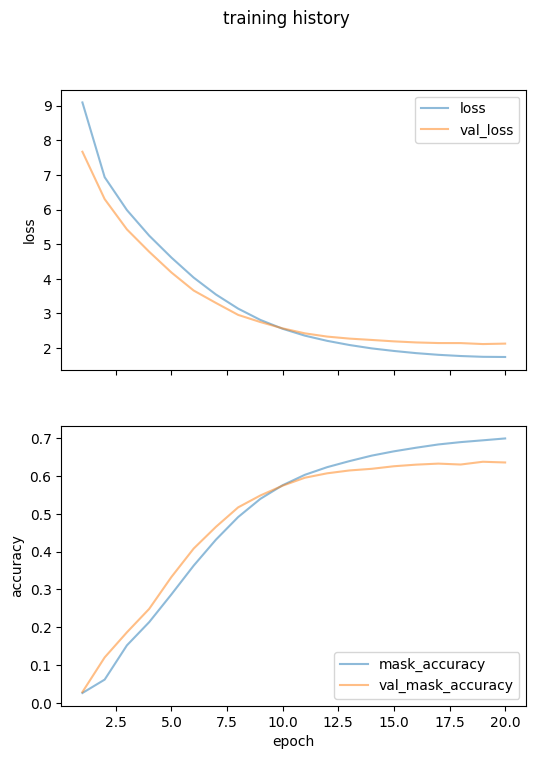

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, figsize = (6,8), sharex = True)
fig.suptitle(
    "training history"
)
x = list(range(1,21))
axes[0].plot(x, history.history['loss'], alpha = 0.5, label = 'loss')
axes[0].plot(x, history.history['val_loss'], alpha = 0.5, label = 'val_loss')
axes[0].set_ylabel('loss')
axes[0].legend(loc = 'upper right')
axes[1].plot(x, history.history['mask_accuracy'], alpha = 0.5, label = 'mask_accuracy')
axes[1].plot(x, history.history['val_mask_accuracy'], alpha = 0.5, label = 'val_mask_accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')
plt.show()

In [ ]:
def translate(sentence):
  enc_tokens = eng_vect([sentence])
  lookup = list(fre_vect.get_vocabulary())
  start_sent, end_sent = "[start]",'[end]'
  output_sent = [start_sent]
  for i in range(seq_length):
    vector = fre_vect([' '.join(output_sent)])
    assert vector.shape == (1, seq_length + 1)
    dec_tokens = vector[:,:-1]
    assert dec_tokens.shape == (1, seq_length)
    pred = model([enc_tokens, dec_tokens])
    assert pred.shape == (1, seq_length, vocab_size_fr)
    word = lookup[np.argmax(pred[0, i, :])]
    output_sent.append(word)
    if word == end_sent:
      break
  return output_sent

In [ ]:
seq_length = 25
vocab_size_en = 10000
vocab_size_fr = 20000
test_count = 20

for n in range(test_count):
  eng_sent, fre_sent = random.choice(test_pair)
  trans = translate(eng_sent)

  print(f"Test Case:{n}")
  print(f"English Sentence:{eng_sent}")
  print(f"Translated Value:{' '.join(trans)}")
  print(f"French Sentence:{fre_sent}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:0
English Sentence:tom told me he was looking for mary.
Translated Value:[start] m'a dit qu'il cherchait marie.[end] marie.[end] à marie.[end] à mary.[end] mary.[end] marie.[end] à marie.[end] mary.[end] mary.[end] mary.[end] mary.[end] mary.[end] mary.[end] à mary.[end] mary.[end] mary.[end] mary.[end]
French Sentence:[start]tom m'a dit qu'il cherchait mary.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:1
English Sentence:i love to help others.
Translated Value:[start] de aider les autres.[end] à [UNK] ![end] ![end] à pied.[end] ![end] ![end] ![end] à pied.[end] ![end] ![end] à pied.[end] à l'autre.[end] des l'autre.[end] l'autre.[end] l'autre.[end]
French Sentence:[start]j'adore aider les autres.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:2
English Sentence:fill this out, please.
Translated Value:[start] ça s'il te plaît.[end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end]
French Sentence:[start]remplissez ceci, je vous prie ![end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:3
English Sentence:they are watching.
Translated Value:[start] [UNK] les [UNK] [UNK] ![end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end]
French Sentence:[start]ils regardent.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:4
English Sentence:the soldiers could do nothing until spring.
Translated Value:[start] ne pouvait faire de plus en printemps.[end] au printemps.[end] du printemps.[end] du printemps.[end] du printemps.[end] au printemps.[end] du printemps.[end] du printemps.[end] possible.[end] possible.[end] du printemps.[end]
French Sentence:[start]les soldats ne purent rien entreprendre jusqu'au printemps.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:5
English Sentence:tom is a chimney sweep.
Translated Value:[start] est un peux de [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] ![end] en [UNK] [UNK] [UNK] un [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
French Sentence:[start]tom est ramoneur.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:6
English Sentence:he was tricked into doing it.
Translated Value:[start] [UNK] en ce qui l'a [UNK] en faire.[end] [UNK] [UNK] [UNK] [UNK] le faire.[end] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
French Sentence:[start]il a été persuadé de le faire par la ruse.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-package

Test Case:7
English Sentence:"where have you been?" "i have been to the station to see a friend off."
Translated Value:[start] que tu dois te faire face à voir la gare pour aller à un ami à un ami [UNK] [UNK] à un ami [UNK] à
French Sentence:[start]"où es-tu allé ?" "je suis allé à la gare saluer le départ d'un ami."[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:8
English Sentence:it gave me the creeps.
Translated Value:[start] trouvé la dont il me [UNK] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end]
French Sentence:[start]ça m'a foutu les jetons.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:9
English Sentence:sorry to bother you, but i'm afraid something urgent has come up.
Translated Value:[start] de te mettre mais moins de manger quelque chose qui a l'air [UNK] [UNK] [UNK] [UNK] [UNK] peut vous [UNK] quelque chose.[end] à temps.[end] »[end]
French Sentence:[start]désolé de vous déranger mais je crains que quelque chose d'urgent soit survenu.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:10
English Sentence:what was it that brought you to me?
Translated Value:[start] à toi de me ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end]
French Sentence:[start]qu'est-ce qui t'a mené à moi ?[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:11
English Sentence:he did the work on his own.
Translated Value:[start] le travail en seul.[end] par moi-même.[end] la main.[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] par moi-même.[end] par moi-même.[end] ?[end] ?[end] ?[end] [UNK]
French Sentence:[start]il a fait le travail lui-même.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:12
English Sentence:i got up earlier than usual.
Translated Value:[start] plus tôt que d'habitude.[end] d'habitude.[end] comme d'habitude.[end] d'habitude.[end] d'habitude.[end] la journée.[end] d'habitude.[end] d'habitude.[end] d'habitude.[end] d'habitude.[end] d'habitude.[end] un coup de temps.[end] d'habitude.[end] d'habitude.[end] d'habitude.[end] d'habitude.[end] d'habitude.[end]
French Sentence:[start]je me suis levé plus tôt que d'habitude.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-package

Test Case:13
English Sentence:is it going to rain today?
Translated Value:[start] à pleuvoir aujourd'hui ?[end] aujourd'hui ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end]
French Sentence:[start]va-t-il pleuvoir aujourd'hui ?[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:14
English Sentence:that's a good point.
Translated Value:[start] vraiment bon.[end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] ![end] bien.[end] ![end] ![end] ![end] ![end] ![end] bien.[end] un bien.[end] bien.[end] ![end] bien.[end]
French Sentence:[start]c'est une bonne remarque.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist

Test Case:15
English Sentence:i had to make a choice.
Translated Value:[start] à trouver le choix.[end] du choix.[end] du choix.[end] qui m'a [UNK] qui m'a besoin.[end] le choix.[end] [UNK] [UNK] un choix.[end] un choix.[end] [UNK] [UNK] à
French Sentence:[start]il m'a fallu effectuer un choix.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-package

Test Case:16
English Sentence:the weather was gorgeous.
Translated Value:[start] était sérieux.[end] comme ça.[end] ![end] ![end] le temps.[end] ![end] ![end] ![end] ![end] ![end] »[end] »[end] ça.[end] le temps.[end] son temps.[end] »[end] »[end] ça.[end] ça.[end] ça.[end]
French Sentence:[start]le temps était superbe.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-package

Test Case:17
English Sentence:how do you know?
Translated Value:[start] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end] ?[end]
French Sentence:[start]comment le sais-tu ?[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-package

Test Case:18
English Sentence:the early bird gets the worm.
Translated Value:[start] de se remettre le [UNK] qui se passe le [UNK] de [UNK] ![end] en [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] »[end]
French Sentence:[start]l'avenir appartient à ceux qui se lèvent tôt.[end]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-package

Test Case:19
English Sentence:this morning i missed the train i usually take.
Translated Value:[start] que je n'avais pas le train où je me [UNK] à prendre.[end] à prendre.[end] visite.[end] visite.[end] visite.[end] à visite.[end] en temps.[end] visite.[end] visite.[end] à pied.[end]
French Sentence:[start]ce matin j'ai raté le train que je prends d'habitude.[end]
